In [105]:
%load_ext autoreload
%autoreload 1
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%aimport base 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Create Cases
bounds = [(1,3),(5,9),(9,10)]
means = [int(np.ceil(sum(b)/2)) for b in bounds]
stds = [np.sqrt(((b[1] - b[0] + 1)**2 - 1)/12)for b in bounds]
types = range(len(bounds))
cases = [0,1,1,1,2,2,2]

In [ ]:
sampler = [lambda size,a=a,b=b: np.random.random_integers(a,b,size = size) for a,b in bounds]
Sampler_C = base.Sampler(types,sampler)

In [ ]:
D = 40 
T = 8
beta = 1.5
gamma = 2.5
alpha = 0.001

N = len(cases) #Number of cases
S = 10000 #Number of steps in algorithm
TC = np.zeros(S) #Total Cost
IC = np.zeros(S) # Idle Cost
WC = np.zeros(S) # Waiting Cost
OC = np.zeros(S) # Overtime Cost

WT = np.zeros((S,N)) #Warning times
K = np.zeros((S,N)) #Mapping of which surgery to warn in
G = np.zeros(N) #Gradient

SE = np.zeros(N) #Expected Start times of surgeries

# First, Initialize the Start times using mean and std
for i in range(1,N):
    SE[i] = SE[i-1] + means[cases[i-1]] + 0.5 * stds[cases[i-1]]

# Second, compute warning times
for i in range(1,N):
    WT[0,i] = max(0,SE[i] - T)
    
#Third, find the surgeries during which the warnings should take place
K[:,0] = -1
for i in range(1,N):
    if WT[0,i] == 0:
        K[0,i] == -1
    else:
        for k in range(i):
            if(SE[k] < WT[0,i]):
                K[0,i] = k
        WT[0,i] =  WT[0,i] - SE[K[0,i]]

SD = np.zeros(N) #Surgery Durations
ST = np.zeros((S,N)) #Start times of surgeries
Y = np.zeros((S,N)) #End time of Surgaries
A = np.zeros(N)
B = np.zeros(N)
C = np.zeros(N)

for s in range(S-1):
    
    #First, Generate Samples
    for i in range(N):
        SD[i] = Sampler_C.sample(cases[i])
        
    #Second, generate start and end times based of Warning Times and Durations
    Y[s,0] = SD[0]
    for i in range(1,N):
        if K[s,i] == -1:
            ST[s,i] = Y[s,i-1]
        else:
            scheduled = ST[s,K[s,i]] + min(WT[s,i],SD[K[s,i]]) + T
            ST[s,i] = max(Y[s,i-1], scheduled)
        Y[s,i] =  ST[s,i] + SD[i]
        
    #Third, Compute A,B, and C
    BC = np.ones(N)
    for i in range(1,N):
        if(ST[s,i] == Y[s,i-1]):
            A[i] = 1
        else:
            A[i] = 0
            
    for i in range(N-1,0,-1):
        BC[i] = BC[i]*(1-A[i])
        B[i] = 1-BC[i]
    
    for i in range(N):
        if(Y[s,N-1] >  D):
            C[i] = BC[i]
        else:
            C[i] = 0;
            
    for i in range(1,N):
        G[i] = A[i] + beta*(1-A[i])*BC[i] + gamma*(1-A[i])*C[i]
    
    #Calculate Average Cost
    for i in range(1,N):
        if K[s,i] != -1:
            temp = ST[s,K[s,i]]+min(WT[s,i],SD[K[s,i]]) + T - Y[s,i-1]
            V = max(0,temp)
        else:
            V = max(0,WT[s,i]+T-Y[s,i-1])
        WC[s+1] += V/(s+1)
        IC[s+1] += (beta*max(0,ST[s,i]-Y[s,i-1]))/(s+1)
    WC[s+1] += (s*WC[s])/(s+1)
    IC[s+1] += (s*IC[s])/(s+1)
    OC[s+1] = (s*IC[s]+gamma*max(0,Y[s,N-1] - D))/(s+1)
    TC[s+1] = WC[s+1] + IC[s+1] + OC[s+1] 
    
    #Update Gradient
    for i in range(1,N):
        WT[s+1,i] = max(0,WT[s,i] - alpha * G[i])
        
    #Check for Negative warning times
    for i in range(1,N):
        if WT[s+1,i] == 0:
            if K[s,i] == -1:
                K[s+1,i] = -1
            else:
                K[s+1,i] = K[s,i]-1
                if(K[s+1,i] != -1):
                    WT[s+1,i] = SD[K[s+1,i]] -1;
                else:
                    WT[s+1,i] = 0
        else:
            K[s+1,i] = K[s,i]
            
    #Check for increasing WT
    for i in range(1,N):
        if WT[s+1,i] > SD[i]:
            WT[s+1,i] = 1
            K[s+1,i] = min(K[s,i] + 1 ,N)
    

In [ ]:
plt.plot(TC)
#plt.plot(WC)
#plt.plot(IC)
#plt.plot(OC)

In [ ]:
M = 1000 #Test Set Size
test_set = np.zeros((M,N))
for i in range(N):
    test_set[:,i] = Sampler_C.sample(cases[i],M)
    
Start = np.zeros((M,N))
End = np.zeros((M,N))

End[:,0] = test_set[:,0]
for i in range(1,N):
    if K[-1,i] == -1:
        Start[:,i] = End[:,i-1]
    else:
        scheduled = Start[:,K[-1,i]] + np.minimum(WT[-1,i],test_set[:,K[-1,i]]) + T
        Start[:,i] = np.maximum(End[:,i-1], scheduled)
    End[:,i] =  Start[:,i] + test_set[:,i]

#Calculate Average Cost
Waiting = 0
Idle = 0
for i in range(1,N):
    if K[-1,i] != -1:
        temp = Start[:,K[-1,i]]+np.minimum(WT[-1,i],test_set[:,K[-1,i]]) + T - End[:,i-1]
        V = np.maximum(0,temp)
    else:
        V = np.maximum(0,WT[-1,i]+T-End[:,i-1])
    Waiting += np.sum(V)/M
    Idle = np.sum(beta*np.maximum(0,Start[:,i]-End[:,i-1]))/M
    
Over = np.sum(gamma*np.maximum(0,End[:,-1] - D))/M
Total = Waiting +Idle+Over
print(Waiting)
print(Idle)
print(Over)
print(Total)

In [ ]:
base.calculate_cost(WT[-1],K[-1],cases,Sampler_C,beta, gamma,T,D)

In [ ]:
P = base.gradient(cases,Sampler_C,alpha,beta,gamma,D,T)

In [ ]:
base.calculate_cost(P[0],P[1],cases,Sampler_C,beta,gamma,T,D)

In [183]:
#Create Cases
X = np.array( [[2,3,4,8, 0],
[4,6,8,12, 0],
[6,8, 10, 14, 0],
[6, 8, 12 ,14, 0],
[8, 12, 16, 24, 0]] )
P = [[0.3, 0.3, 0.3, 0.1, 0],
[0.3, 0.3, 0.3, 0.1, 0],
[0.3, 0.3, 0.3, 0.1, 0],
[0.25, 0.25, 0.25, 0.25, 0],
[0.2,0.2,0.2,0.4,0]]
cases = [0,2,2,2,3]
sampler = [lambda size,a=a,b=b: np.random.choice(a,p=b,size = size) for a,b in zip(X,P)]
types = range(len(X))
Sampler_C = base.Sampler(types,sampler)

In [216]:
D = 40 
T = 8
beta = 1.5
gamma = 2.5
alpha = 0.001
Res = base.gradient(cases,Sampler_C,alpha,beta,gamma,D,T,S=100000)

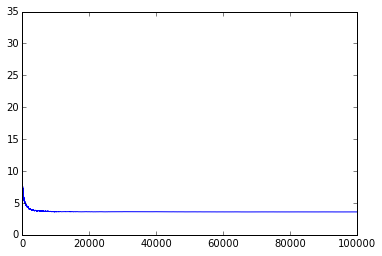

In [217]:
plt.plot(Res[2])

In [218]:
base.calculate_cost(Res[0][-1],Res[1][-1],cases,Sampler_C,beta,gamma,T,D,M=100000)

(23.933214562500314,
 12.943385790000312,
 3.7608836850000014,
 7.2289450875000023)

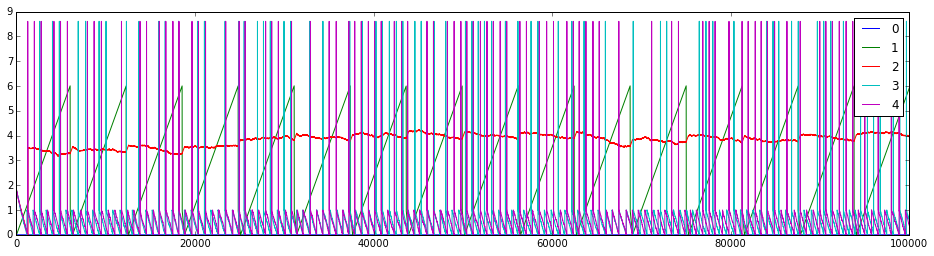

In [212]:
plt.figure(figsize=(16,4))
for i in range(Res[0].shape[1]):
    plt.plot(Res[0][:,i], label = "{0}".format(i))
plt.legend()

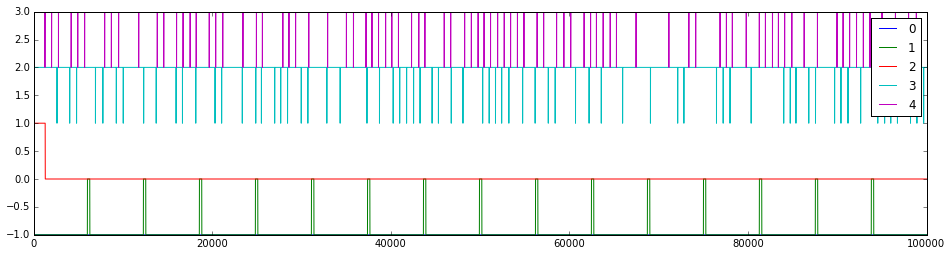

In [213]:
plt.figure(figsize=(16,4))
for i in range(Res[1].shape[1]):
    plt.plot(Res[1][:,i], label = "{0}".format(i))
plt.legend()

In [180]:
M = np.sum(np.multiply(X,P),axis=1)
S = np.sum(np.multiply(X**2,P),axis=1)
S = np.sqrt(S-M**2)
print(M)
print(S)

[  3.5   6.6   8.6  10.   16.8]
[ 1.6881943   2.37486842  2.37486842  3.16227766  6.4       ]


In [85]:
np.std(Sampler_C.sample(0,10000))

1.6593686028125276

In [55]:
np.multiply(X**2,P)

array([[   1.2,    2.7,    4.8,    6.4,    0. ],
       [   4.8,   10.8,   19.2,   14.4,    0. ],
       [  10.8,   19.2,   30. ,   19.6,    0. ],
       [   9. ,   16. ,   36. ,   49. ,    0. ],
       [  12.8,   28.8,   51.2,  345.6,    0. ]])

In [56]:
np.multiply(X,P)

array([[  0.6,   0.9,   1.2,   0.8,   0. ],
       [  1.2,   1.8,   2.4,   1.2,   0. ],
       [  1.8,   2.4,   3. ,   1.4,   0. ],
       [  1.5,   2. ,   3. ,   3.5,   0. ],
       [  1.6,   2.4,   3.2,  14.4,   0. ]])